# Predicting whether a student is in a romantic relationship
By Sébastien Rhéaume, Ryan Shar, Justin Wong, Robert Yip

Student Performance Data set  
https://archive.ics.uci.edu/ml/datasets/Student+Performance 

### Initialize settings:

In [86]:
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)
set.seed(1)


Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine




## Introduction
Romance is often a big part of a student's life for high school students. In our study, we look at three factors to assess whether we can predict if a student is in a relationship. Our selected factors to look at includes the **student's age**, the **student's number of absences**, and the **student's grade**. We chose these factors because we think these are good predictors on whether a student is in a relationship, based on what is available from our data set. For example, an older student may be more likely to be in a relationship, and if they are in a relationship, they may skip school more often and result in lower grades.

Our data set consists of 395 secondary students from two Portuguese schools. Each observation in the data set represents a student, with information on the student's characteristics (including family information). The data is collected through questionnaires. See below for more detailed information on the variables we looked at:

**romantic (categorical)** - our classification target. The outcome is binary: either yes or no to indicate the student's relationship status.  
**age (numeric)** - represents a student's age  
**absences (numeric)** - represents the count of absences in the term  
**overall_grade (numeric)** - represents the student's math grades over 3 periods, out of a maximum of 60. The original data set had 3 different grades (G1, G2, and G3), each representing the grade in a period. Since we are more interested in a student's overall grades than a single grade from a particular period, we combined the grades as a simplification for our study.

## Methods

### Load Data
We read our data from the url below, unzip it, and store it as *raw_data*.

In [23]:
# Dataset
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/00320/student.zip"

# Read into table
temp <- tempfile()
download.file(url,temp)
raw_data <- read_csv2(unz(temp, "student-mat.csv"))
#print.data.frame(head(raw_data))     # print.data.frame is needed because the table is wide and has collapsed columns

Using ',' as decimal and '.' as grouping mark. Use read_delim() for more control.

Parsed with column specification:
cols(
  .default = col_character(),
  age = col_double(),
  Medu = col_double(),
  Fedu = col_double(),
  traveltime = col_double(),
  studytime = col_double(),
  failures = col_double(),
  famrel = col_double(),
  freetime = col_double(),
  goout = col_double(),
  Dalc = col_double(),
  Walc = col_double(),
  health = col_double(),
  absences = col_double(),
  G1 = col_double(),
  G2 = col_double(),
  G3 = col_double()
)

See spec(...) for full column specifications.



### Clean/Wrangle Data
We select the factors we want to look at and combine the 3 period grades into one by summing them.  
We also convert our target variable (romantic) into a factor, which is more useful than the default string.

In [24]:
# Select columns and combine grades
data <- raw_data %>%
    select (romantic, age, absences, G1, G2, G3) %>%
    mutate (overall_grade = G1 + G2 + G3) %>%
    select (-G1, -G2, -G3) %>%
    mutate(romantic = as_factor(romantic))

data

romantic,age,absences,overall_grade
<fct>,<dbl>,<dbl>,<dbl>
no,18,6,17
no,17,4,16
no,15,10,25
⋮,⋮,⋮,⋮
no,21,3,25
no,18,0,33
no,19,5,26


We also check for n/a, and we find that no data is missing.

In [25]:
sum(is.na(data))

[1] 0

### Split data for training and testing
We consider our data set to be small in size, since we only have 395 observations. We apply a conservative 70-30 split for training and testing. We set *strata* to our target factor (romantic).

In [26]:
data_split <- initial_split(data, prop = 0.70, strata = romantic)  
data_train <- training(data_split)   
data_test <- testing(data_split)

#data_train
#data_test

### Summary of training data so far
Before we continue on, we review a summary of our training set to understand our data better. The table below shows that in our training set:

- 278 of the 395 observations were used in our training set.
- The mean age of our students in the training set is around 16.66 years old.
- Students in the training set skip 5.9 classes on average.
- The mean math grade of the students in the training set is 31.72 out of 60.
- We also confirm that none of our data is n/a.

We expect comparable data for our testing set when we confirm it later.

In [27]:
# Summary
data_train %>% summarise(number_of_rows = nrow(data_train),
      mean_age = mean(age),
      mean_absences = mean(absences),
      mean_grade = mean(overall_grade),
      number_of_na = sum(is.na(data_train)))

number_of_rows,mean_age,mean_absences,mean_grade,number_of_na
<int>,<dbl>,<dbl>,<dbl>,<int>
278,16.65827,5.938849,31.71942,0


### Recipe
Next, we create our recipe. We set our target variable to be the *romantic* factor, and we set our three predictor variables (age, absences, and grade) in our training data set. We also scale our predictors to make them comparable. This is necessary as 1 year in age does not scale the same as 1 point in grade, as the latter likely have a larger variance.

In [28]:
# Setup recipe to use all 3 factors as predictors for romantic.
student_recipe <- recipe(romantic ~ ., data = data_train) %>% 
                    step_scale(all_predictors()) %>%
                    step_center(all_predictors())
#student_recipe

### Validation Set
For our validation set, we split our data into 5 chunks for a standard 5-fold cross-validation.

In [29]:
# Set 5-fold cross-validation.
data_vfold <- vfold_cv(data_train, v = 5, strata = romantic)
#data_vfold

### Model Specification with tune
Next we create our model specifications. We want to predict using K-nearest neighbours, so we call the *nearest_neighbor()* function. Since we do not know which *K* to use at this point, we set *neighbours = tune()* to find the appropriate K value. We use "rectangular" for *weight_func* as a simple straight-line distance for the k-nn. The engine is set to "kknn" for k-nn, and the mode is set to "classification" since our target variable is a binary factor. 

In [30]:
# Setup model specification
knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors= tune()) %>%
      set_engine("kknn") %>%
      set_mode("classification")

### Determining which K-neighbors to use
In this step, we combine our recipe and model to figure out the best K to use for our prediction.

In [31]:
# Produce table of accuracies at different K-neighbors.
knn_results <- workflow() %>%
      add_recipe(student_recipe) %>%
      add_model(knn_tune) %>%
      tune_grid(resamples = data_vfold, grid = 20) %>%
      collect_metrics()
knn_results

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.6118182,5,0.02582314,Model01
1,roc_auc,binary,0.5454876,5,0.02929841,Model01
2,accuracy,binary,0.6118182,5,0.02702980,Model02
⋮,⋮,⋮,⋮,⋮,⋮,⋮
14,roc_auc,binary,0.5262921,5,0.02290346,Model14
15,accuracy,binary,0.6514935,5,0.02442534,Model15
15,roc_auc,binary,0.5434645,5,0.02573819,Model15


The above table shows the accuracy at different K values. Let us generate a plot to show the accuracy at different K values.

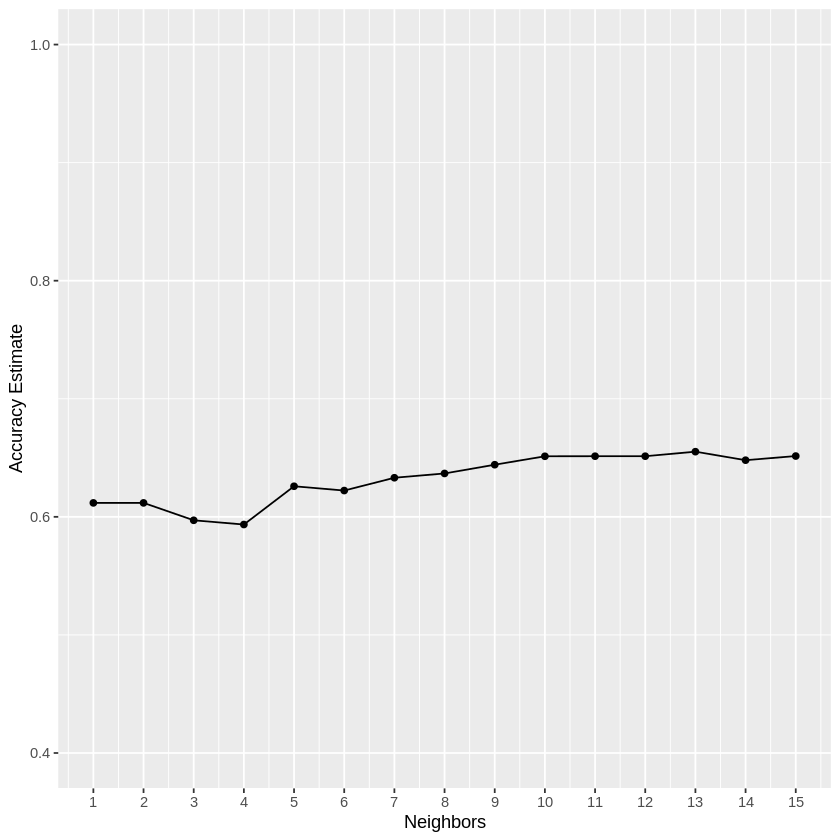

In [32]:
# For our metrics, we only want to look at accuracy.
accuracies <- knn_results %>% 
    filter(.metric == "accuracy")

# Create our plot.
accuracy_versus_k <- ggplot(accuracies, aes(x = neighbors, y = mean))+
    geom_point() +
    geom_line() +
    labs(x = "Neighbors", y = "Accuracy Estimate") +
    scale_x_continuous(breaks = seq(0, 20, by = 1)) +  # adjusting the x-axis
    scale_y_continuous(limits = c(0.4, 1.0)) # adjusting the y-axis

accuracy_versus_k

From the plot, it looks like the accuracy of our estimate is highest when $K=13$. Note that this is true based on our current $seed = 1$, our prediction is based on this seed.  
Let us confirm this is the case by sorting our data and extracting the row with the highest accuracy.

In [34]:
max_k <- knn_results %>%
    filter(.metric =="accuracy") %>%
    arrange(desc(mean)) %>%
    slice(1)
max_k

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
13,accuracy,binary,0.6551948,5,0.03050929,Model13


The table above confirms accuracy is highest when $K=13$, with an accuracy of $65.5%$.

### Prediction
We can now put all the above together. We set our neighbors to 13 in our model specification based on our previous step. We create our workflow and fit our it to our training set.

In [38]:
student_model <- nearest_neighbor(weight_func = "rectangular", neighbors = 8) %>%
    set_engine("kknn") %>%
    set_mode("classification")

student_workflow <- workflow() %>%
    add_model(student_model) %>%
    add_recipe(student_recipe)

student_fit <- fit(student_workflow, data = data_train)

student_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

● step_scale()
● step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = ~8, kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.3417266
Best kernel: rectangular
Best k: 8

With the training completed from above, we can now predict using our test set. The table below shows the test set with a new column *.pred_class*. This is the model's prediction based on the training above, and it can be compared to the romantic column which represent the *truth* on whether the student is really dating.

In [39]:
student_test_predictions <- predict(student_fit , data_test) %>%
     bind_cols(data_test)
student_test_predictions

.pred_class,romantic,age,absences,overall_grade
<fct>,<fct>,<dbl>,<dbl>,<dbl>
no,yes,15,2,44
no,no,15,2,31
no,no,16,4,42
⋮,⋮,⋮,⋮,⋮
no,yes,20,4,44
yes,no,19,0,11
no,no,18,14,16


We can further summarize the table above to compute the accuracy of our prediction, by calculating the percentage of when the prediction matches the actual relationship status.  
The table below shows the prediction is correct 73% of the time. An accuracy of 73% is quite good, we can be quite confident in our model.

In [42]:
student_prediction_accuracy <- student_test_predictions %>%
        metrics(truth = romantic, estimate = .pred_class) %>%
        filter(.metric == "accuracy")
student_prediction_accuracy

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7179487


## Visualization
In order to visualize how well our predictor variables fit, we can create multiple plots for each factor variable. We chose to create 3 separate plots, one for each predictor variable, as combining all 3 into 1 graph is more messy.

Since we are creating a plot for each predictor variable, we use a histogram as the predictor variable is continuous data. Each plot shows a count of the students at each x, and we use fill to highlight how many students are in a romantic relationship.

In [102]:
#Settings for plot dimensions
options(repr.plot.width = 8, repr.plot.height = 12) 

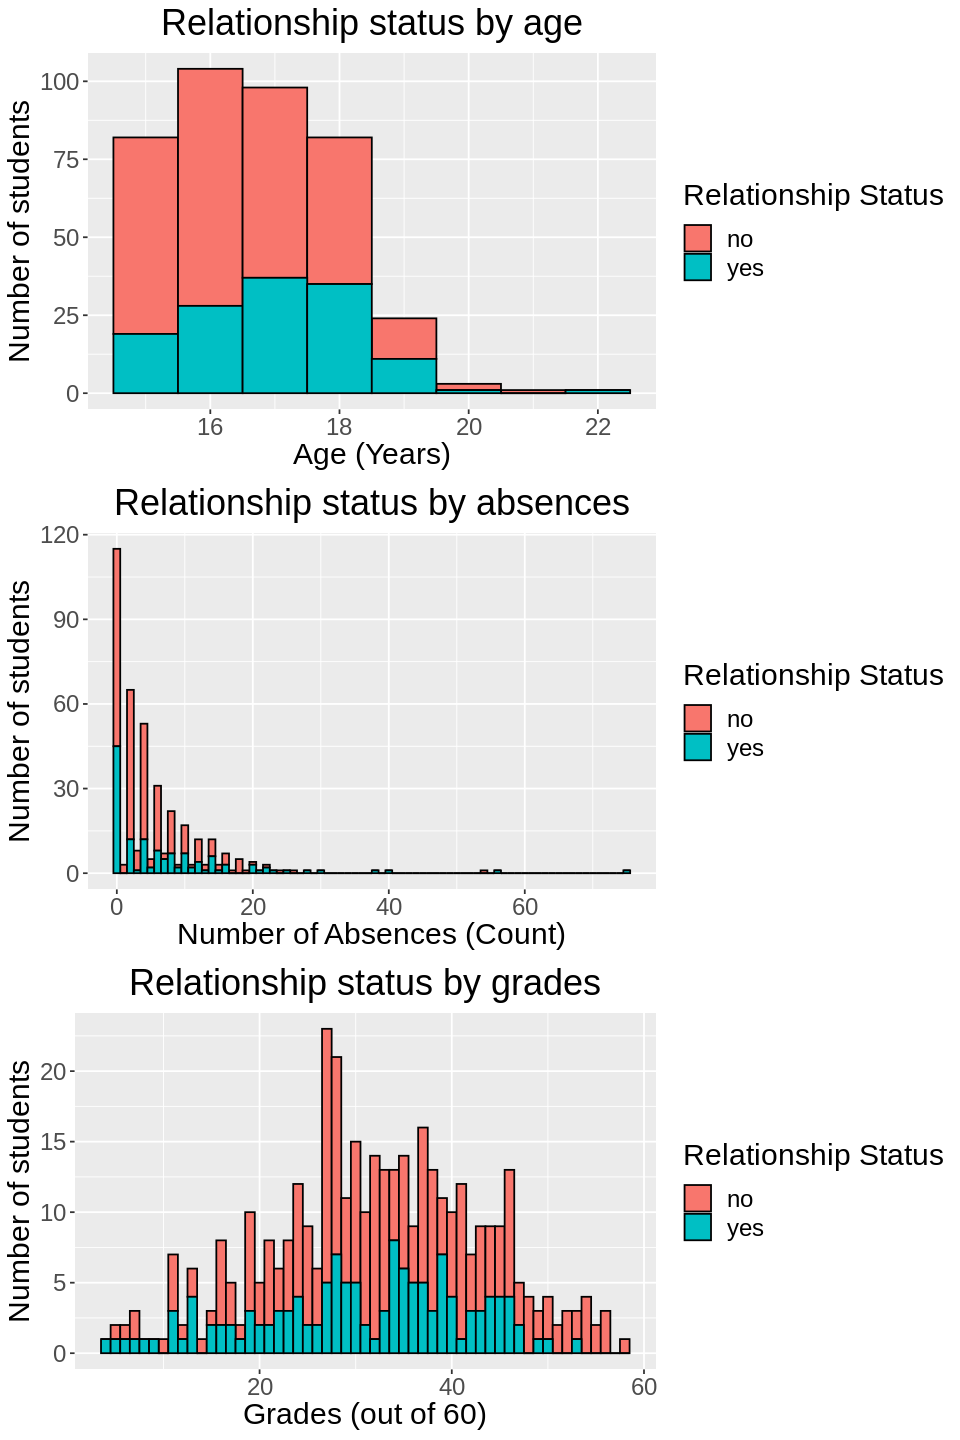

In [103]:
data_plot_age <- ggplot(data, aes(x=age, fill=romantic)) +
    geom_histogram(color="black", binwidth=1) +
    theme(text=element_text(size=18), plot.title = element_text(hjust = 0.5)) + 
    labs(x="Age (Years)", y="Number of students", fill="Relationship Status") +
    ggtitle("Relationship status by age")

data_plot_absences <- ggplot(data, aes(x=absences, fill=romantic)) +
    geom_histogram(color="black", binwidth=1) +
    theme(text=element_text(size=18), plot.title = element_text(hjust = 0.5)) + 
    labs(x="Number of Absences (Count)", y="Number of students", fill="Relationship Status") +
    ggtitle("Relationship status by absences")

data_plot_grade <- ggplot(data, aes(x=overall_grade, fill=romantic)) +
    geom_histogram(color="black", binwidth=1) +
    theme(text=element_text(size=18), plot.title = element_text(hjust = 0.5)) + 
    labs(x="Grades (out of 60)", y="Number of students", fill="Relationship Status") +
    ggtitle("Relationship status by grades")

grid.arrange(data_plot_age, data_plot_absences, data_plot_grade)

## Discussion on plots
[...]